<a href="https://colab.research.google.com/github/Flurame/MRT/blob/main/MRT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from termcolor import colored

# Пути к данным (Google Drive)
base_path = r"/content/drive/MyDrive/BreastMRI"
train_healthy = os.path.join(base_path, "train", "Healthy")
train_sick = os.path.join(base_path, "train", "Sick")
valid_healthy = os.path.join(base_path, "vaild", "Healthy")
valid_sick = os.path.join(base_path, "vaild", "Sick")

# Проверяем, что папки существуют
paths = [train_healthy, train_sick, valid_healthy, valid_sick]
for path in paths:
    if os.path.exists(path):
        print(f"✓ {path}: {len(os.listdir(path))} файлов")
    else:
        print(f"✗ {path} не существует!")

# Смотрим примеры файлов
print("\nПримеры файлов в train/Health:")
for f in os.listdir(train_healthy)[:5]:
    print(f"  {f}")

✓ /content/drive/MyDrive/BreastMRI/train/Healthy: 700 файлов
✓ /content/drive/MyDrive/BreastMRI/train/Sick: 700 файлов
✓ /content/drive/MyDrive/BreastMRI/vaild/Healthy: 40 файлов
✓ /content/drive/MyDrive/BreastMRI/vaild/Sick: 40 файлов

Примеры файлов в train/Health:
  H_174.jpg
  H_12.jpg
  H_168.jpg
  H_169.jpg
  H_163.jpg


In [ ]:
# КОНФИГУРАЦИЯ
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 16

# Правильные пути для flow_from_directory
train_dir = os.path.join(base_path, "train")
valid_dir = os.path.join(base_path, "vaild")  # ← vaild с опечаткой!

print(f"Train directory: {train_dir}")
print(f"Valid directory: {valid_dir}")
print()

# 1. Тренировочный генератор с аугментацией
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='reflect'  # Для медицинских изображений лучше reflect
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True,
    seed=42
)

# 2. Валидационный генератор (только нормализация)
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,  # ← Здесь тоже vaild
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False  # Не перемешиваем валидацию!
)

print(f"\nКлассы: {train_generator.class_indices}")
print(f"Train samples: {train_generator.samples}")
print(f"Valid samples: {valid_generator.samples}")
print(f"Train batches per epoch: {len(train_generator)}")
print(f"Valid batches per epoch: {len(valid_generator)}")

Train directory: /content/drive/MyDrive/BreastMRI/train
Valid directory: /content/drive/MyDrive/BreastMRI/vaild

Found 1400 images belonging to 2 classes.
Found 80 images belonging to 2 classes.

Классы: {'Healthy': 0, 'Sick': 1}
Train samples: 1400
Valid samples: 80
Train batches per epoch: 88
Valid batches per epoch: 5



Визуализация тренировочных данных:


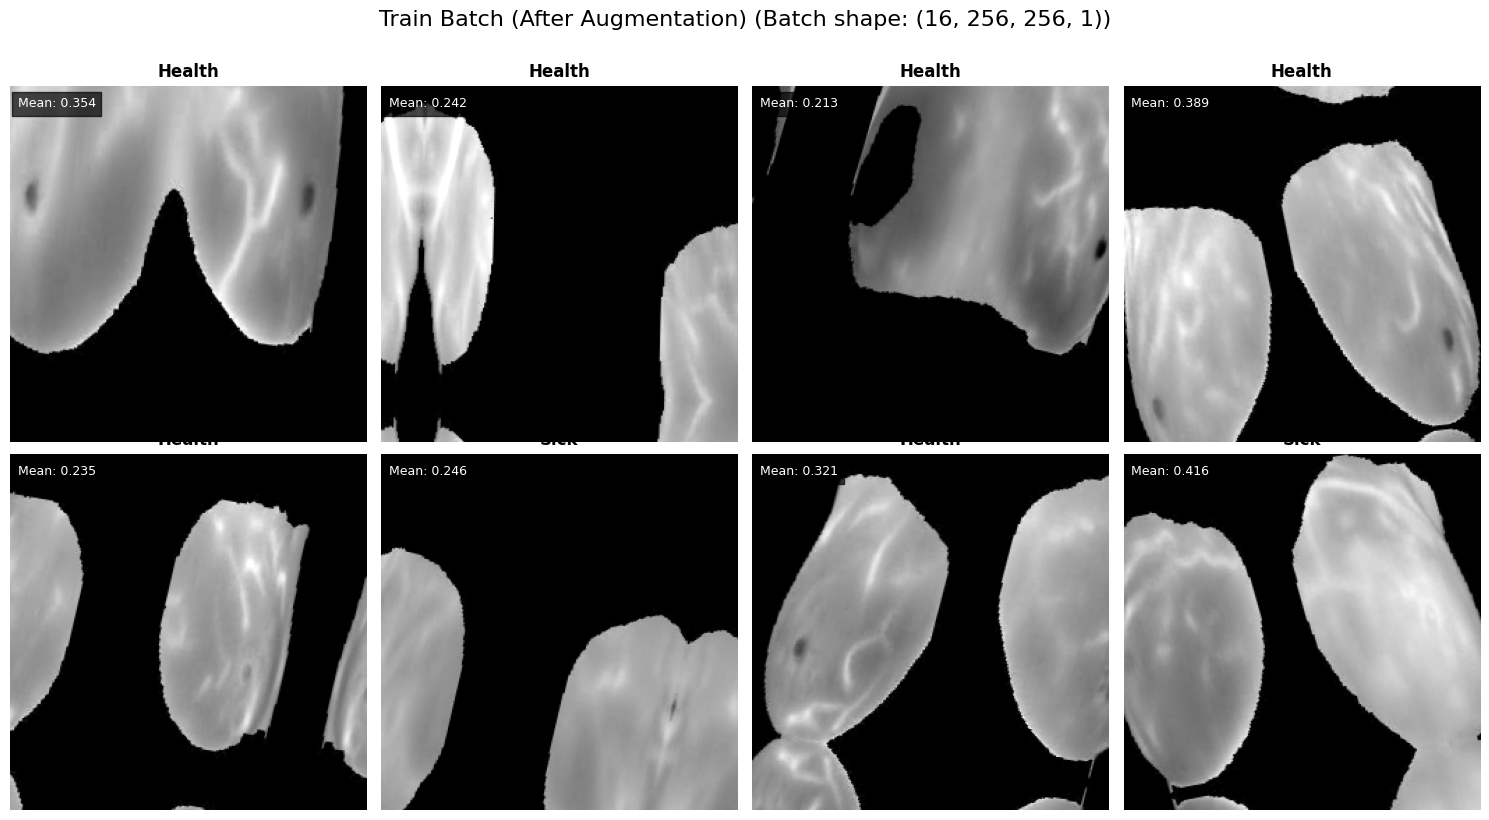


Визуализация валидационных данных:


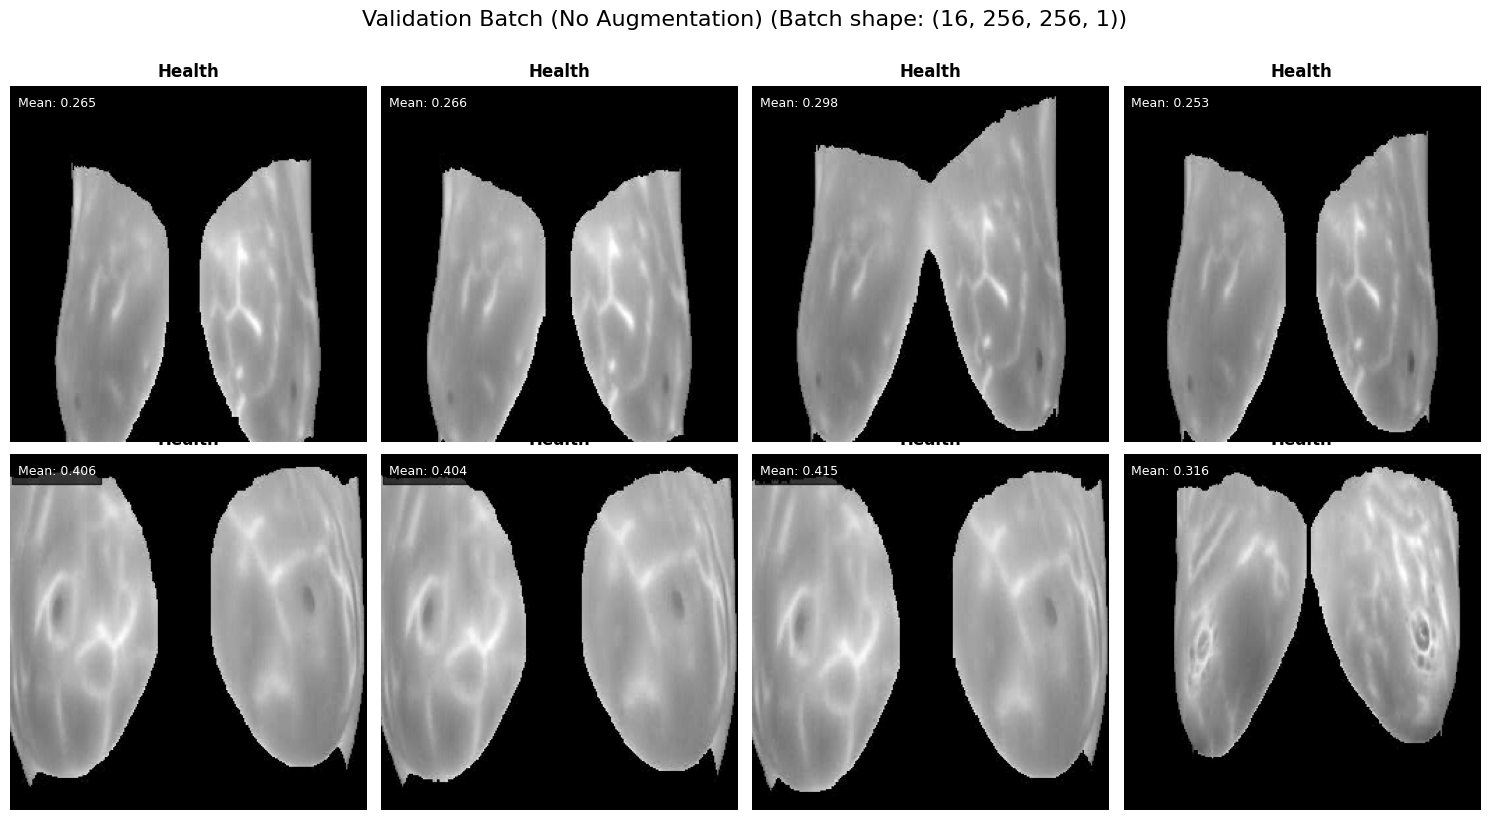

In [ ]:
# Визуализируем батч данных
def visualize_data_samples(generator, title, num_samples=8):
    """Визуализирует выборку данных из генератора"""
    images, labels = next(generator)

    plt.figure(figsize=(15, 8))
    for i in range(min(num_samples, len(images))):
        plt.subplot(2, 4, i+1)
        img = images[i].squeeze()
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)

        # Гистограмма интенсивности маленькая на графике
        plt.text(5, 15, f"Mean: {img.mean():.3f}",
                color='white', fontsize=9,
                bbox=dict(facecolor='black', alpha=0.7))

        class_name = "Health" if labels[i] == 0 else "Sick"
        plt.title(f"{class_name}", fontsize=12, fontweight='bold')
        plt.axis('off')

    plt.suptitle(f"{title} (Batch shape: {images.shape})", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Визуализация
print("\nВизуализация тренировочных данных:")
visualize_data_samples(train_generator, "Train Batch (After Augmentation)")

print("\nВизуализация валидационных данных:")
visualize_data_samples(valid_generator, "Validation Batch (No Augmentation)")

In [ ]:
def create_cnn_model(input_shape=(256, 256, 1), dropout_rate=0.3):
    """Создает CNN модель для классификации МРТ изображений"""
    model = models.Sequential([
        # Блок 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                     input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate/2),

        # Блок 2
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        # Блок 3
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        # Блок 4
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        # Полносвязные слои
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate/2),

        # Выходной слой
        layers.Dense(1, activation='sigmoid')
    ])

    return model

# Создание и компилирование модели
model = create_cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1))

# Компиляция с оптимизатором Adam и метриками
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR')  # Precision-Recall AUC
    ]
)

# Вывод информации о модели
model.summary()

# Визуализация архитектуры
try:
    from tensorflow.keras.utils import plot_model
    plot_model(model, to_file='model_architecture.png',
               show_shapes=True, show_layer_names=True)
    print("\nАрхитектура модели сохранена в model_architecture.png")
except:
    pass

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 626,401 (2.39 MB)

 Trainable params: 624,609 (2.38 MB)

 Non-trainable params: 1,792 (7.00 KB)


Архитектура модели сохранена в model_architecture.png


In [ ]:
# Коллбэки для обучения
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',  # Мониторим AUC (лучше чем accuracy для несбалансированных данных)
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_breast_mri_model.keras',
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=1
    )
]

# Рассчитываем шаги
train_steps = len(train_generator)
valid_steps = len(valid_generator)

print(f"\nПараметры обучения:")
print(f"Train samples: {train_generator.samples}")
print(f"Valid samples: {valid_generator.samples}")
print(f"Train steps per epoch: {train_steps}")
print(f"Valid steps per epoch: {valid_steps}")
print(f"Batch size: {BATCH_SIZE}")

# Обучаем модель
EPOCHS = 30

print(f"\n{'='*60}")
print("НАЧИНАЕМ ОБУЧЕНИЕ МОДЕЛИ")
print(f"{'='*60}")

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Параметры обучения:
Train samples: 1400
Valid samples: 80
Train steps per epoch: 88
Valid steps per epoch: 5
Batch size: 16

НАЧИНАЕМ ОБУЧЕНИЕ МОДЕЛИ


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5364 - auc: 0.5750 - loss: 0.8439 - pr_auc: 0.5478 - precision: 0.5347 - recall: 0.5465 
Epoch 1: val_auc improved from -inf to 0.44344, saving model to best_breast_mri_model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 1050s 12s/step - accuracy: 0.5363 - auc: 0.5747 - loss: 0.8439 - pr_auc: 0.5477 - precision: 0.5347 - recall: 0.5463 - val_accuracy: 0.5000 - val_auc: 0.4434 - val_loss: 0.6962 - val_pr_auc: 0.5833 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5600 - auc: 0.5894 - loss: 0.7774 - pr_auc: 0.5717 - precision: 0.5547 - recall: 0.5554 
Epoch 2: val_auc improved from 0.44344 to 0.49687, saving model to best_breast_mri_model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 1028s 12s/step - accuracy: 0.5597 - auc: 0.5890 - loss: 0.7776 - pr_auc: 0.5716 - precision: 0.5544 - recall: 0.5549 - val_accuracy: 0.5000 - val_auc: 0.4969 - val_loss: 0.69

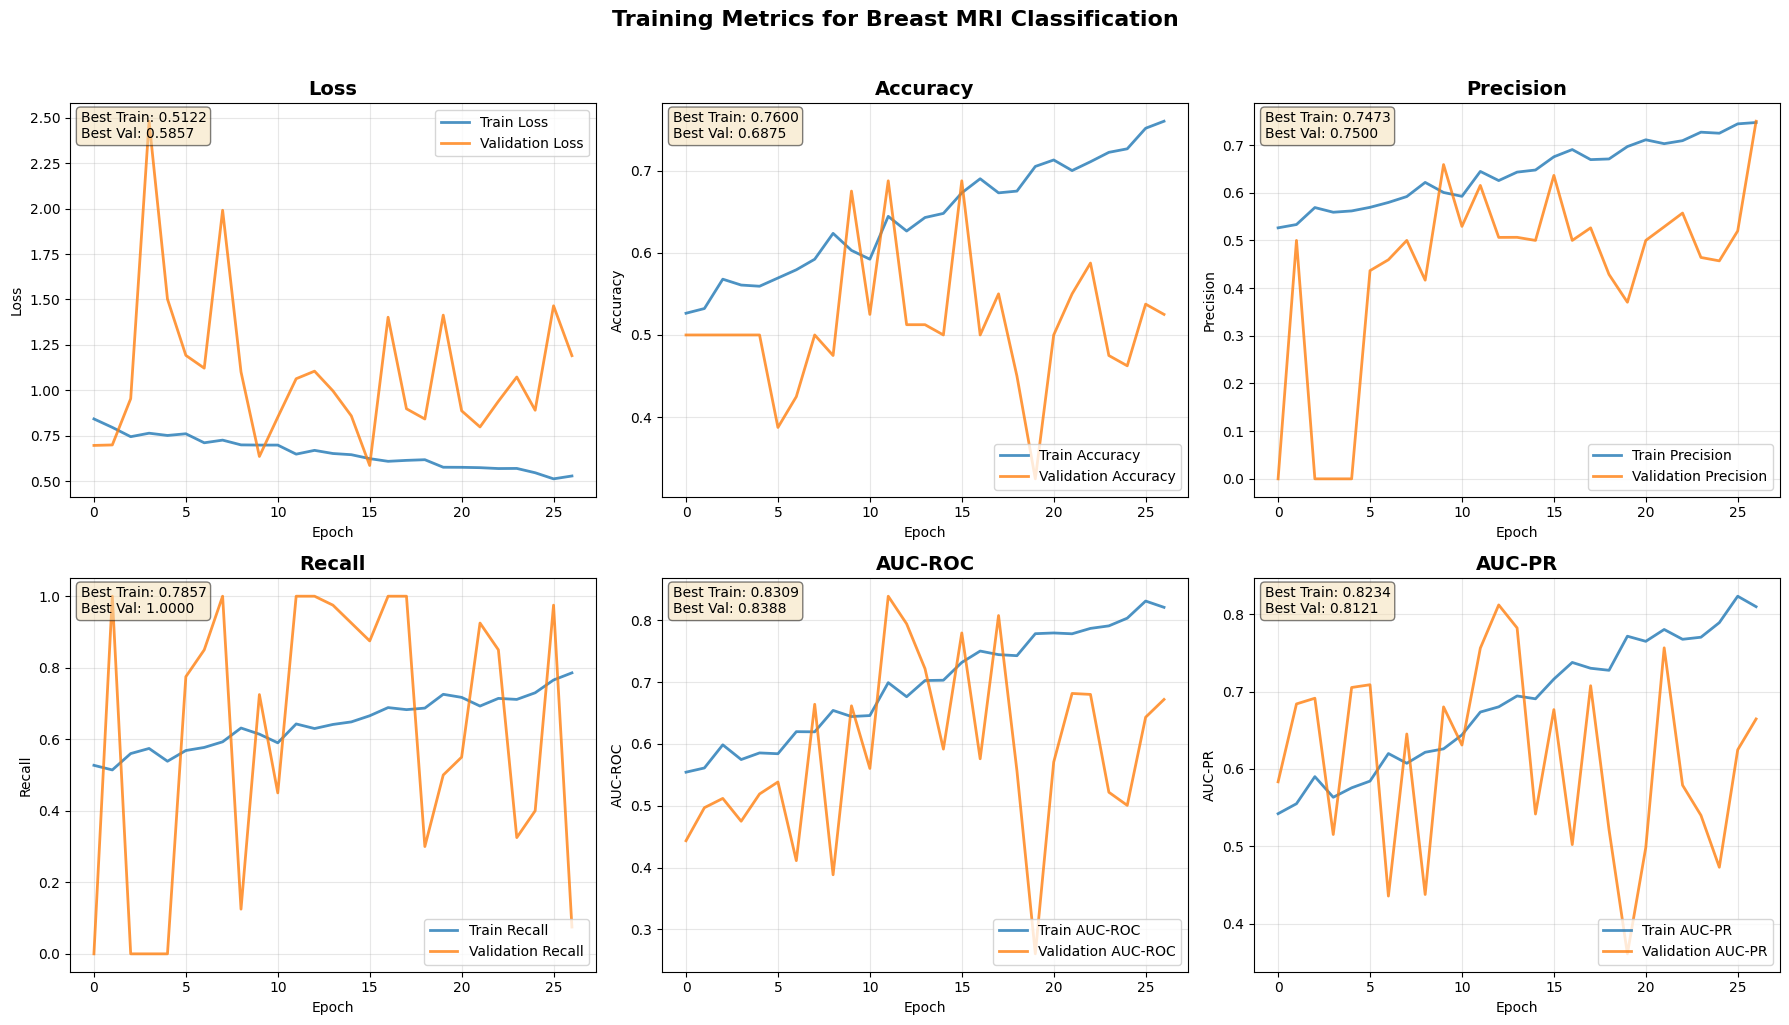

In [ ]:
# Визуализация метрик обучения
def plot_training_metrics(history):

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    metrics_config = [
        ('loss', 'Loss', 'upper right'),
        ('accuracy', 'Accuracy', 'lower right'),
        ('precision', 'Precision', 'lower right'),
        ('recall', 'Recall', 'lower right'),
        ('auc', 'AUC-ROC', 'lower right'),
        ('pr_auc', 'AUC-PR', 'lower right')
    ]

    for idx, (metric, title, legend_loc) in enumerate(metrics_config):
        row, col = divmod(idx, 3)

        axes[row, col].plot(history.history[metric], label=f'Train {title}',
                          linewidth=2, alpha=0.8)
        axes[row, col].plot(history.history[f'val_{metric}'],
                          label=f'Validation {title}', linewidth=2, alpha=0.8)

        axes[row, col].set_title(f'{title}', fontsize=14, fontweight='bold')
        axes[row, col].set_xlabel('Epoch')
        axes[row, col].set_ylabel(title)
        axes[row, col].legend(loc=legend_loc)
        axes[row, col].grid(True, alpha=0.3)

        # Добавляем лучшие значения
        best_train = max(history.history[metric]) if metric != 'loss' else min(history.history[metric])
        best_val = max(history.history[f'val_{metric}']) if metric != 'loss' else min(history.history[f'val_{metric}'])

        axes[row, col].text(0.02, 0.98, f'Best Train: {best_train:.4f}\nBest Val: {best_val:.4f}',
                          transform=axes[row, col].transAxes,
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.suptitle('Training Metrics for Breast MRI Classification',
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Визуализируем результаты
plot_training_metrics(history)

In [ ]:
# Создание модели CNN
def create_cnn_model():
    """
    Создает простую CNN модель для классификации МРТ изображений
    """
    from tensorflow.keras import layers, models

    model = models.Sequential([
        # Первый сверточный блок
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
        layers.MaxPooling2D((2, 2)),

        # Второй сверточный блок
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Третий сверточный блок
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Полносвязные слои
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Для предотвращения переобучения

        # Выходной слой
        layers.Dense(1, activation='sigmoid')  # 0 = здоровый, 1 = больной
    ])

    # Компилируем модель
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print(" Функция create_cnn_model() готова")

 Функция create_cnn_model() готова


In [ ]:
# Загружаем существующую модель или обучаем новую
print(" ЗАГРУЗКА ИЛИ СОЗДАНИЕ МОДЕЛИ")

# Путь для сохранения модели
MODEL_PATH = "/content/drive/MyDrive/BreastMRI/best_breast_mri_model.keras"

if os.path.exists(MODEL_PATH):
    # Загружаем существующую модель
    print(f" Найдена сохраненная модель: {MODEL_PATH}")
    model = tf.keras.models.load_model(MODEL_PATH)
    print(" Модель успешно загружена!")

    # Показываем информацию о модели
    print(f"\nИнформация о модели:")
    print(f"  • Количество слоев: {len(model.layers)}")
    print(f"  • Количество параметров: {model.count_params():,}")
    print(f"  • Входной размер: {model.input_shape}")

else:
    # Если модели нет - создаем и обучаем новую быструю модель
    print(" Сохраненная модель не найдена")
    print("Создаем и обучаем новую модель...")

    # Создаем модель
    model = create_cnn_model()

    # Создаем генераторы данных
    train_datagen = ImageDataGenerator(rescale=1./255)
    valid_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=16,
        class_mode='binary',
        color_mode='grayscale',
        shuffle=True
    )

    valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(256, 256),
        batch_size=16,
        class_mode='binary',
        color_mode='grayscale',
        shuffle=False
    )

    print(f"\n Данные для обучения:")
    print(f"  • Тренировочные изображения: {train_generator.samples}")
    print(f"  • Валидационные изображения: {valid_generator.samples}")
    print(f"  • Классы: {train_generator.class_indices}")

    # Обучаем модель (3 эпохи для быстрого старта)
    print("\n Начинаем обучение (3 эпохи)...")
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        epochs=3,
        verbose=1
    )

    # Сохраняем модель
    model.save(MODEL_PATH)
    print(f"\n Модель сохранена: {MODEL_PATH}")

 ЗАГРУЗКА ИЛИ СОЗДАНИЕ МОДЕЛИ
 Найдена сохраненная модель: /content/drive/MyDrive/BreastMRI/best_breast_mri_model.keras
 Модель успешно загружена!

Информация о модели:
  • Количество слоев: 28
  • Количество параметров: 626,401
  • Входной размер: (None, 256, 256, 1)


In [ ]:
# Блок 5: Функция для анализа изображений
def predict_mri(image_path):
    """
    Анализирует МРТ изображение и определяет, здоровое оно или больное

    Параметры:
        image_path: путь к файлу изображения (.jpg или .png)

    Возвращает:
        prediction: вероятность заболевания (0-1)
        class_name: "Здоровая" или "Больная"
        confidence: уверенность в процентах
        img: само изображение (для отображения)
    """
    # Загружаем изображение
    img = image.load_img(image_path, color_mode='grayscale', target_size=(256, 256))
    img_array = image.img_to_array(img)

    # Нормализуем (как при обучении)
    img_array = img_array / 255.0

    # Добавляем размерность для батча
    img_array = np.expand_dims(img_array, axis=0)

    # Получаем предсказание от модели
    prediction = model.predict(img_array, verbose=0)[0][0]

    # Определяем класс
    if prediction < 0.5:
        class_name = "Здоровая"
        confidence = (1 - prediction) * 100
    else:
        class_name = "Больная"
        confidence = prediction * 100

    return prediction, class_name, confidence, img

print("Функция predict_mri() готова к использованию")

Функция predict_mri() готова к использованию


In [ ]:
# Тестируем модель на случайных изображениях
print(" ТЕСТИРОВАНИЕ МОДЕЛИ НА ВАЛИДАЦИОННЫХ ДАННЫХ")
print(" ")

def test_random_samples(num_samples=5):

    # Собираем все доступные изображения
    all_images = []

    # Здоровые изображения
    healthy_path = os.path.join(valid_dir, "Healthy")
    if os.path.exists(healthy_path):
        healthy_files = [f for f in os.listdir(healthy_path) if f.lower().endswith('.jpg')]
        for file in healthy_files:
            all_images.append(("Healthy", os.path.join(healthy_path, file)))

    # Больные изображения
    sick_path = os.path.join(valid_dir, "Sick")
    if os.path.exists(sick_path):
        sick_files = [f for f in os.listdir(sick_path) if f.lower().endswith('.jpg')]
        for file in sick_files:
            all_images.append(("Sick", os.path.join(sick_path, file)))

    if not all_images:
        print("Нет изображений для тестирования")
        return

    # Выбираем случайные изображения
    if len(all_images) > num_samples:
        test_images = random.sample(all_images, num_samples)
    else:
        test_images = all_images

    print(f"Тестируем {len(test_images)} случайных изображений:\n")

    correct_count = 0

    for i, (true_label, img_path) in enumerate(test_images, 1):
        # Получаем предсказание
        prediction, pred_label, confidence, img = predict_mri(img_path)

        # Проверяем правильность
        is_correct = (true_label == "Healthy" and pred_label == "Здоровая") or \
                     (true_label == "Sick" and pred_label == "Больная")

        if is_correct:
            correct_count += 1

        # Выводим результат
        print(f"{i}. {os.path.basename(img_path)}")
        print(f"   Истинный: {true_label}")
        print(f"   Предсказанный: {pred_label} ({confidence:.1f}%)")
        print(f"   Вероятность заболевания: {prediction:.4f}")
        print(f"   Результат: {' ВЕРНО' if is_correct else ' !ОШИБКА!'}")
        print()

    # Выводим итоговую точность
    accuracy = correct_count / len(test_images) * 100
    print(f" ИТОГО: {correct_count}/{len(test_images)} правильных ({accuracy:.1f}%)")

# Запускаем тестирование
test_random_samples(num_samples=10)

 ТЕСТИРОВАНИЕ МОДЕЛИ НА ВАЛИДАЦИОННЫХ ДАННЫХ
 
Тестируем 10 случайных изображений:

1. S_30.jpg
   Истинный: Healthy
   Предсказанный: Больная (57.5%)
   Вероятность заболевания: 0.5747
   Результат:  !ОШИБКА!

2. S_61.jpg
   Истинный: Sick
   Предсказанный: Больная (98.6%)
   Вероятность заболевания: 0.9861
   Результат:  ВЕРНО

3. S_26.jpg
   Истинный: Healthy
   Предсказанный: Здоровая (67.9%)
   Вероятность заболевания: 0.3213
   Результат:  ВЕРНО

4. S_43.jpg
   Истинный: Sick
   Предсказанный: Больная (99.9%)
   Вероятность заболевания: 0.9990
   Результат:  ВЕРНО

5. S_64.jpg
   Истинный: Sick
   Предсказанный: Больная (96.0%)
   Вероятность заболевания: 0.9600
   Результат:  ВЕРНО

6. S_44.jpg
   Истинный: Healthy
   Предсказанный: Больная (69.3%)
   Вероятность заболевания: 0.6931
   Результат:  !ОШИБКА!

7. S_40.jpg
   Истинный: Sick
   Предсказанный: Больная (100.0%)
   Вероятность заболевания: 0.9995
   Результат:  ВЕРНО

8. S_19.jpg
   Истинный: Healthy
   Предсказанный: З


АНАЛИЗ ВАШЕГО ИЗОБРАЖЕНИЯ

Инструкция по использованию:
1. Загрузите изображение в Google Colab
2. Укажите путь к файлу или выберите номер из списка
3. Получите результат анализа
4. Блок завершится автоматически после анализа

Файлы в текущей папке:
  1. model_architecture.png
  2. S_41.jpg
  3. S_69.jpg

----------------------------------------
Введите путь к файлу или номер: 2

Анализируем: S_41.jpg...

РЕЗУЛЬТАТ АНАЛИЗА:
Вероятность заболевания: 46.6%
Класс: Здоровая
Уверенность модели: 53.4%

------------------------------------------------------------
СРЕДНЯЯ вероятность заболевания
Требуется дополнительное обследование


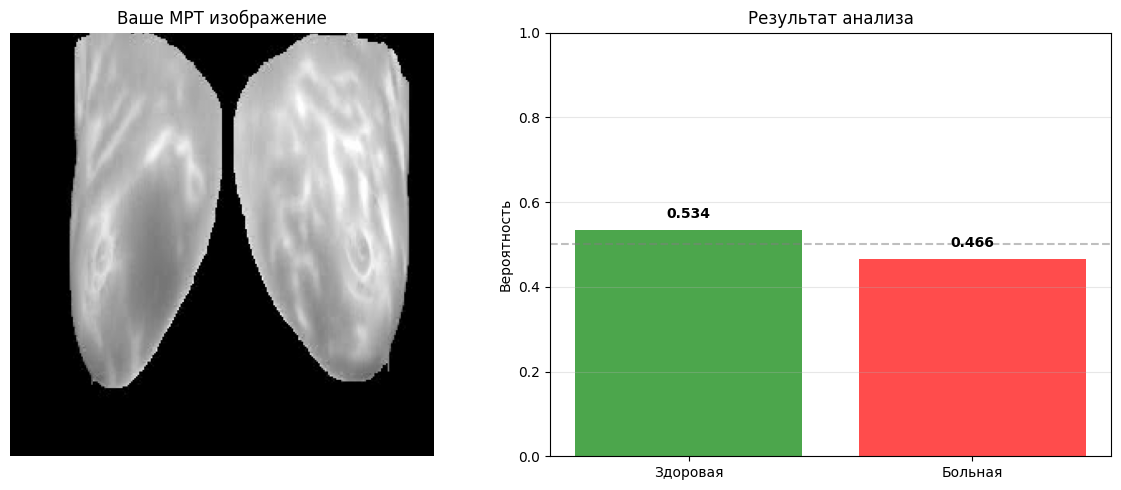


АНАЛИЗ ЗАВЕРШЕН УСПЕШНО


In [ ]:
# Блок 7: Анализ вашего собственного изображения
print("\n" + "="*60)
print("АНАЛИЗ ВАШЕГО ИЗОБРАЖЕНИЯ")
print("="*60)

def analyze_custom_image():
    """Анализирует одно ваше изображение и завершает работу"""

    print("\nИнструкция по использованию:")
    print("1. Загрузите изображение в Google Colab")
    print("2. Укажите путь к файлу или выберите номер из списка")
    print("3. Получите результат анализа")
    print("4. Блок завершится автоматически после анализа")

    # Показываем доступные файлы
    print("\nФайлы в текущей папке:")
    current_files = [f for f in os.listdir() if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if current_files:
        for i, file in enumerate(current_files[:10], 1):
            print(f"  {i}. {file}")
        if len(current_files) > 10:
            print(f"  ... и еще {len(current_files) - 10} файлов")
    else:
        print("  (нет изображений)")

    # Получаем путь к файлу
    print("\n" + "-"*40)
    user_input = input("Введите путь к файлу или номер: ").strip()

    # Если введен номер из списка
    if user_input.isdigit() and current_files:
        idx = int(user_input) - 1
        if 0 <= idx < len(current_files):
            file_path = current_files[idx]
        else:
            print("Неверный номер")
            return
    else:
        file_path = user_input

    # Проверяем существование файла
    if not os.path.exists(file_path):
        print(f"Файл не найден: {file_path}")
        return

    try:
        # Анализируем изображение
        print(f"\nАнализируем: {os.path.basename(file_path)}...")
        prediction, class_name, confidence, img = predict_mri(file_path)

        # Выводим результат
        print("\n" + "="*60)
        print("РЕЗУЛЬТАТ АНАЛИЗА:")
        print("="*60)
        print(f"Вероятность заболевания: {prediction:.1%}")
        print(f"Класс: {class_name}")
        print(f"Уверенность модели: {confidence:.1f}%")
        print("\n" + "-"*60)

        # Рекомендации
        if prediction > 0.7:
            print("ВЫСОКАЯ вероятность заболевания")
            print("Рекомендуется консультация специалиста")
        elif prediction < 0.3:
            print("НИЗКАЯ вероятность заболевания")
        else:
            print("СРЕДНЯЯ вероятность заболевания")
            print("Требуется дополнительное обследование")

        # Визуализация
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Левая часть: изображение
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title("Ваше МРТ изображение")
        axes[0].axis('off')

        # Правая часть: график вероятности
        colors = ['green', 'red']
        classes = ['Здоровая', 'Больная']
        probabilities = [1 - prediction, prediction]

        bars = axes[1].bar(classes, probabilities, color=colors, alpha=0.7)
        axes[1].set_title(f"Результат анализа")
        axes[1].set_ylabel('Вероятность')
        axes[1].set_ylim([0, 1])
        axes[1].grid(True, alpha=0.3, axis='y')

        # Добавляем значения
        for bar, prob in zip(bars, probabilities):
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                        f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')

        # Линия порога
        axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

        print("\n" + "="*60)
        print("АНАЛИЗ ЗАВЕРШЕН УСПЕШНО")
        print("="*60)

    except Exception as e:
        print(f"Ошибка при анализе: {e}")
        print("Убедитесь, что файл является изображением .jpg или .png")

# Запускаем анализ (один раз)
analyze_custom_image()